# DoS Attack Simulation and Detection
This notebook demonstrates results of the DoS attacks simulation and detection using Python. We will analyze the logged data to answer several questions regarding detected attacks.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import folium

In [2]:
# Load the detected attacks data
log_file = "detected_attacks.csv"
df = pd.read_csv(log_file)

# Display the first few rows of the dataframe
df.head()

,Timestamp,Source IP,Attack Type,Bytes Transferred,Packet Count
0,2024-10-17 23:29:55,243.29.156.32,syn_flood,2700,50
1,2024-10-17 23:29:55,243.29.156.32,syn_flood,2700,50
2,2024-10-17 23:29:55,17.134.142.62,syn_flood,2700,50
3,2024-10-17 23:29:55,17.134.142.62,syn_flood,2700,50
4,2024-10-17 23:29:55,141.253.101.187,syn_flood,2700,50


## Suspect IP Addresses
In this section, we will analyze the source IP addresses involved in the detected attacks and map their geographical locations.

In [3]:
# Get unique source IP addresses
suspect_ips = df['Source IP'].unique()

# Function to get location data for IP addresses
def get_ip_location(ip):
    try:
        response = requests.get(f"http://ip-api.com/json/{ip}").json()
        return response['country'], response['city'], response['lat'], response['lon']
    except:
        return "Unknown", "Unknown", None, None

# Create a DataFrame to store IP location data
location_data = []

for ip in suspect_ips:
    country, city, lat, lon = get_ip_location(ip)
    if lat is not None and lon is not None:
        location_data.append({'IP': ip, 'Country': country, 'City': city, 'Latitude': lat, 'Longitude': lon})

locations_df = pd.DataFrame(location_data)

# Display the locations DataFrame
locations_df

,IP,Country,City,Latitude,Longitude
0,17.134.142.62,United States,Cupertino,37.3217,-122.03000
1,141.253.101.187,Spain,Madrid,40.4168,-3.70379
2,210.134.209.79,Japan,Chiyoda,35.6906,139.77000
3,65.39.173.227,Canada,Montreal,45.5075,-73.58870
4,136.218.117.243,United States,Sierra Vista,31.5552,-110.35000
...,...,...,...,...,...
65,136.76.95.59,United States,Dearborn,42.3223,-83.17630
66,175.251.57.210,South Korea,Seongnam-si,37.3654,127.12200
67,120.81.80.133,China,Shenzhen,22.5429,114.06000
68,86.71.199.176,France,Varages,43.5986,5.95750


## Attacks by Country
In this section, we will visualize the number of attacks detected in different countries based on the location of the source IP addresses


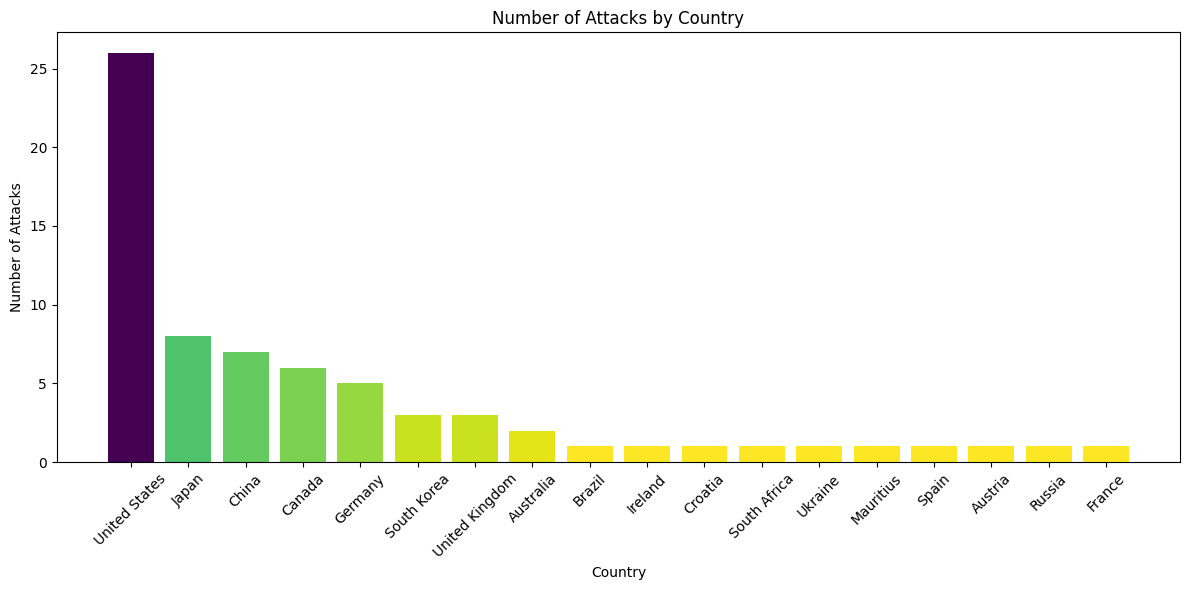

In [4]:
# Group the data by country and count the number of attacks
attacks_by_country = locations_df['Country'].value_counts()

# Normalize the data to map the colormap correctly
norm = plt.Normalize(attacks_by_country.min(), attacks_by_country.max())
cmap = plt.cm.viridis.reversed()

# Plot the number of attacks by country with the viridis colormap
plt.figure(figsize=(12, 6))
bars = plt.bar(attacks_by_country.index, attacks_by_country.values, 
               color=cmap(norm(attacks_by_country.values)))
plt.title('Number of Attacks by Country')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Mapping Suspect IP Addresses
We will visualize the locations of the suspect IP addresses on a map.

In [5]:
# Create a map centered around a specified location
map_center = [20, 0]  # Center the map around the equator
my_map = folium.Map(location=map_center, zoom_start=2)

# Add markers for each suspect IP location
for _, row in locations_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"IP: {row['IP']}, Country: {row['Country']}, City: {row['City']}",
    ).add_to(my_map)

# Display the map
my_map

## Attack Analysis
In this section, we will answer the following questions:
1. What is the attack that generated the most packets?
2. What is the attack that generated the largest traffic in terms of bytes?
3. What is the attack that generated the largest traffic in bytes per second?

In [6]:
# Group by attack type and count packets
most_packets = df.groupby('Attack Type')['Packet Count'].sum().idxmax()
most_packets_count = df.groupby('Attack Type')['Packet Count'].sum().max()

most_packets, most_packets_count

('smurf', 2800)

In [7]:
# Group by attack type and sum bytes transferred
largest_traffic = df.groupby('Attack Type')['Bytes Transferred'].sum().idxmax()
largest_traffic_bytes = df.groupby('Attack Type')['Bytes Transferred'].sum().max()

largest_traffic, largest_traffic_bytes

('pod', 989900)

In [8]:
# Convert the 'Timestamp' column to datetime if it's not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Group the data by the attack type
attack_groups = df.groupby('Attack Type').agg(
    total_bytes=('Bytes Transferred', 'sum'),
    start_time=('Timestamp', 'min'),
    end_time=('Timestamp', 'max')
).reset_index()
attack_groups['duration'] = (attack_groups['end_time'] - attack_groups['start_time']).dt.total_seconds()

# Calculate traffic per second
attack_groups['traffic_per_second'] = attack_groups['total_bytes'] / attack_groups['duration']
largest_traffic_bps = attack_groups.loc[attack_groups['traffic_per_second'].idxmax(), 'Attack Type']
largest_traffic_bps_value = attack_groups.loc[attack_groups['traffic_per_second'].idxmax(), 'traffic_per_second']
largest_traffic_bps, largest_traffic_bps_value

('pod', 98990.0)

## Conclusion
In this notebook, we successfully simulated and detected DoS attacks. We analyzed the logged data to identify:
- The attack that generated the most packets.
- The attack that generated the largest traffic in terms of bytes.
- The attack that generated the largest traffic in bytes per second.

In [9]:
attack_groups["packets"] = df.groupby("Attack Type")["Packet Count"].sum().reset_index()["Packet Count"]
attack_groups

,Attack Type,total_bytes,start_time,end_time,duration,traffic_per_second,packets
0,pod,989900,2024-10-17 23:29:56,2024-10-17 23:30:06,10.0,98990.0,950
1,smurf,117600,2024-10-17 23:29:59,2024-10-17 23:30:09,10.0,11760.0,2800
2,syn_ack,105300,2024-10-17 23:29:58,2024-10-17 23:30:08,10.0,10530.0,1950
3,syn_flood,140400,2024-10-17 23:29:55,2024-10-17 23:30:05,10.0,14040.0,2600
